In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pydrake.multibody.plant import MultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.math import RigidTransform
plt.rcParams["figure.figsize"] = (13, 7)

In [1]:
model_url = "/home/xuanhien/git/dairlib/examples/trifinger/robot_properties_fingers/urdf/edu/trifingeredu.urdf"
plant = MultibodyPlant(time_step=0)
(trifingeredu, ) = Parser(plant).AddModels(model_url)
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"), RigidTransform.Identity())
plant.Finalize()
plant_context = plant.CreateDefaultContext()


def calc_vel(positions, timestamps):
    assert positions.shape[0] == timestamps.shape[0]
    vels = []

    for i in range(positions.shape[0]-1):
        vels.append((positions[i+1] - positions[i]) / (timestamps[i+1] - timestamps[i]))

    return np.array(vels)

def calc_accel(velocities, timestamps):
    assert velocities.shape[0] == timestamps.shape[0]
    accelerations = []

    for i in range(velocities.shape[0]-1):
        accelerations.append((velocities[i+1] - velocities[i]) / (timestamps[i+1] - timestamps[i]))
    accelerations.append(np.zeros(velocities.shape[1]))

    return np.array(accelerations)

def compute_component_torques(positions, velocities, accelerations, torques, plant, plant_context):
    assert positions.shape[0] == torques.shape[0]
    assert accelerations.shape[0] == torques.shape[0]
    friction_torques = np.zeros_like(torques)
    id_torques = np.zeros_like(torques)
    
    for i in range(positions.shape[0]):
        # set plant to desired configuration and compute gravity force.
        position = np.zeros(9)
        position[:3] = positions[i]
        vel = np.zeros(9)
        vel[:3] = velocities[i]
        plant.SetPositions(plant_context, position)
        plant.SetVelocities(plant_context, vel)
        
        # compute accel, coriolis, and gravity terms.
        gravity_torque = plant.CalcGravityGeneralizedForces(plant_context)[:3]
        bias_torque = plant.CalcBiasTerm(plant_context)[:3]
        accel_torque = plant.CalcMassMatrix(plant_context)[:3, :3] @ accelerations[i]
        
        # subtract all above terms from the actual torques to estimate the friction torques.
        # minus sign for gravity torque is because drake put gravity term in the right-hand side of the manipulator equation
        id_torques[i] = bias_torque + accel_torque - gravity_torque
        friction_torques[i] = torques[i] - id_torques[i]
    return friction_torques, id_torques

NameError: name 'MultibodyPlant' is not defined

In [3]:
plant.GetVelocityNames()

['trifingeredu_finger_base_to_upper_joint_0_w',
 'trifingeredu_finger_upper_to_middle_joint_0_w',
 'trifingeredu_finger_middle_to_lower_joint_0_w',
 'trifingeredu_finger_base_to_upper_joint_120_w',
 'trifingeredu_finger_upper_to_middle_joint_120_w',
 'trifingeredu_finger_middle_to_lower_joint_120_w',
 'trifingeredu_finger_base_to_upper_joint_240_w',
 'trifingeredu_finger_upper_to_middle_joint_240_w',
 'trifingeredu_finger_middle_to_lower_joint_240_w']

In [4]:
########## Data for finger 0 ##########
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_17-Jun-2024_18_32_01.npy"
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_18-Jun-2024_18_49_21_small_torque.npy" # reduce amplitude of input signal to 0.1 Nm
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_18-Jun-2024_19_11_09_slower.npy" # increase period of input signal to 4s
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_18-Jun-2024_19_21_44_slower.npy"
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_18-Jun-2024_19_32_43_slower_sending.npy" # sending same torque 2 times
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_18-Jun-2024_20_14_06_square_signal.npy" # sending square signal
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_18-Jun-2024_20_23_16_very_small_torque.npy" # torque amp is 0.05 Nm, too small, finger does not move.
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_18-Jun-2024_20_30_26_very_small_torque.npy" # torque amp is 0.075 Nm, finger barely move.
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_24-Jun-2024_13_41_12_small_vel_damping.npy"
# finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_24-Jun-2024_13_58_32_small_vel_damping.npy"
finger0_lower_joint_file_name = "finger0_ramp_up_torque_motions_lower_joint_24-Jun-2024_14_09_57_small_vel_damping.npy"
finger0_middle_joint_file_name = "finger0_ramp_up_torque_motions_middle_joint_14-Jun-2024_19_28_41.npy"
finger0_upper_joint_file_name = "finger0_ramp_up_torque_motions_upper_joint_14-Jun-2024_19_27_00.npy"

########## Data for finger 2 ##########
# finger2_lower_joint_file_name = "finger2_ramp_up_torque_motions_lower_joint_17-Jun-2024_19_03_45.npy"
finger2_lower_joint_file_name = "finger2_ramp_up_torque_motions_lower_joint_17-Jun-2024_19_33_06.npy"
finger2_middle_joint_file_name = "finger2_ramp_up_torque_motions_middle_joint_14-Jun-2024_19_38_23.npy"
finger2_upper_joint_file_name = "finger2_ramp_up_torque_motions_upper_joint_14-Jun-2024_19_39_44.npy"
data = {"finger0": {}, "finger2": {}}
data["finger0"]["lower"] = np.load(finger0_lower_joint_file_name, allow_pickle=True).item()
data["finger0"]["middle"] = np.load(finger0_middle_joint_file_name, allow_pickle=True).item()
data["finger0"]["upper"] = np.load(finger0_upper_joint_file_name, allow_pickle=True).item()
data["finger2"]["lower"] = np.load(finger2_lower_joint_file_name, allow_pickle=True).item()
data["finger2"]["middle"] = np.load(finger2_middle_joint_file_name, allow_pickle=True).item()
data["finger2"]["upper"] = np.load(finger2_upper_joint_file_name, allow_pickle=True).item()

In [5]:
# filtering noises from velocities
window_length = 101
polyorder = 4
vel_finger0_lower = data["finger0"]["lower"]["velocities"]
vel_finger0_middle = data["finger0"]["middle"]["velocities"]
vel_finger0_upper = data["finger0"]["upper"]["velocities"]
filtered_vel_finger0_lower = savgol_filter(data["finger0"]["lower"]["velocities"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_vel_finger0_middle = savgol_filter(data["finger0"]["middle"]["velocities"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_vel_finger0_upper = savgol_filter(data["finger0"]["upper"]["velocities"], window_length=window_length, polyorder=polyorder, axis=0)

filtered_vel_finger2_lower = savgol_filter(data["finger2"]["lower"]["velocities"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_vel_finger2_middle = savgol_filter(data["finger2"]["middle"]["velocities"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_vel_finger2_upper = savgol_filter(data["finger2"]["upper"]["velocities"], window_length=window_length, polyorder=polyorder, axis=0)

accel_finger0_lower = calc_accel(filtered_vel_finger0_lower, data["finger0"]["lower"]["timestamps"])
accel_finger0_middle = calc_accel(filtered_vel_finger0_middle, data["finger0"]["middle"]["timestamps"])
accel_finger0_upper = calc_accel(filtered_vel_finger0_upper, data["finger0"]["upper"]["timestamps"])
accel_finger2_lower = calc_accel(filtered_vel_finger2_lower, data["finger2"]["lower"]["timestamps"])
accel_finger2_middle = calc_accel(filtered_vel_finger2_middle, data["finger2"]["middle"]["timestamps"])
accel_finger2_upper = calc_accel(filtered_vel_finger2_upper, data["finger2"]["upper"]["timestamps"])

In [6]:
# filtering noises from torques
torque_finger0_lower = data["finger0"]["lower"]["measured_torques"]
torque_finger0_middle = data["finger0"]["middle"]["measured_torques"]
torque_finger0_upper = data["finger0"]["upper"]["measured_torques"]
torque_finger2_lower = data["finger2"]["lower"]["measured_torques"]
torque_finger2_middle = data["finger2"]["middle"]["measured_torques"]
torque_finger2_upper = data["finger2"]["upper"]["measured_torques"]
filtered_torque_finger0_lower = savgol_filter(data["finger0"]["lower"]["measured_torques"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_torque_finger0_middle = savgol_filter(data["finger0"]["middle"]["measured_torques"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_torque_finger0_upper = savgol_filter(data["finger0"]["upper"]["measured_torques"], window_length=window_length, polyorder=polyorder, axis=0)

filtered_torque_finger2_lower = savgol_filter(data["finger2"]["lower"]["measured_torques"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_torque_finger2_middle = savgol_filter(data["finger2"]["middle"]["measured_torques"], window_length=window_length, polyorder=polyorder, axis=0)
filtered_torque_finger2_upper = savgol_filter(data["finger2"]["upper"]["measured_torques"], window_length=window_length, polyorder=polyorder, axis=0)

In [7]:
friction_torques_finger0_lower, id_torques_finger0_lower = compute_component_torques(data["finger0"]["lower"]["positions"], filtered_vel_finger0_lower, accel_finger0_lower, filtered_torque_finger0_lower, plant, plant_context)
friction_torques_finger0_middle, id_torques_finger0_middle = compute_component_torques(data["finger0"]["middle"]["positions"], filtered_vel_finger0_middle, accel_finger0_middle, filtered_torque_finger0_middle, plant, plant_context)
friction_torques_finger0_upper, id_torques_finger0_upper = compute_component_torques(data["finger0"]["upper"]["positions"], filtered_vel_finger0_upper, accel_finger0_upper, filtered_torque_finger0_upper, plant, plant_context)

friction_torques_finger2_lower, id_torques_finger2_lower = compute_component_torques(data["finger2"]["lower"]["positions"], filtered_vel_finger2_lower, accel_finger2_lower, filtered_torque_finger2_lower, plant, plant_context)
friction_torques_finger2_middle, id_torques_finger2_middle = compute_component_torques(data["finger2"]["middle"]["positions"], filtered_vel_finger2_middle, accel_finger2_middle, filtered_torque_finger2_middle, plant, plant_context)
friction_torques_finger2_upper, id_torques_finger2_upper = compute_component_torques(data["finger2"]["upper"]["positions"], filtered_vel_finger2_upper, accel_finger2_upper, filtered_torque_finger2_upper, plant, plant_context)

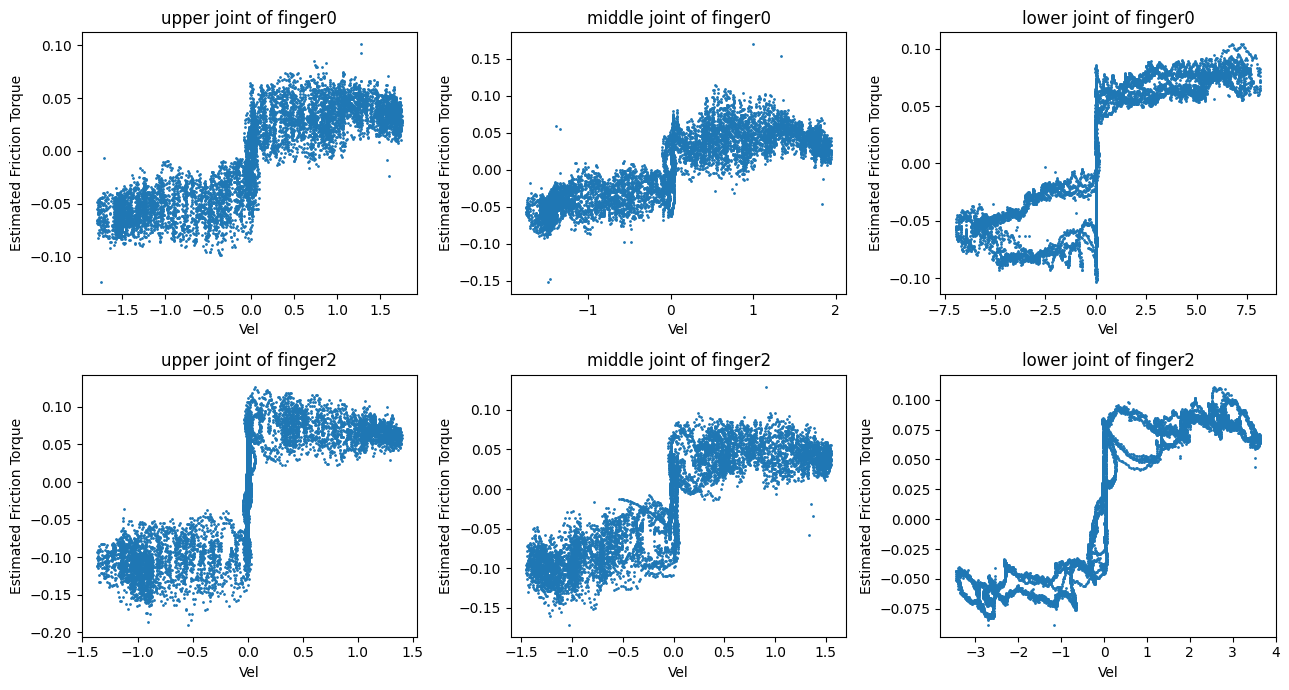

In [7]:
fig, ax = plt.subplots(2, 3)
finger_names = ["finger0", "finger2"]
joint_names = ["upper", "middle", "lower"]

for i, finger in enumerate(finger_names):
    for j, joint in enumerate(joint_names):
        ax[i, j].scatter(locals()[f"filtered_vel_{finger}_{joint}"][1000:, j], locals()[f"friction_torques_{finger}_{joint}"][1000:, j], s=1)
        ax[i, j].set_xlabel("Vel")
        ax[i, j].set_ylabel("Estimated Friction Torque")
        ax[i, j].set_title(f"{joint} joint of {finger}")
plt.tight_layout()

Text(0, 0.5, 'Torque (Nm)')

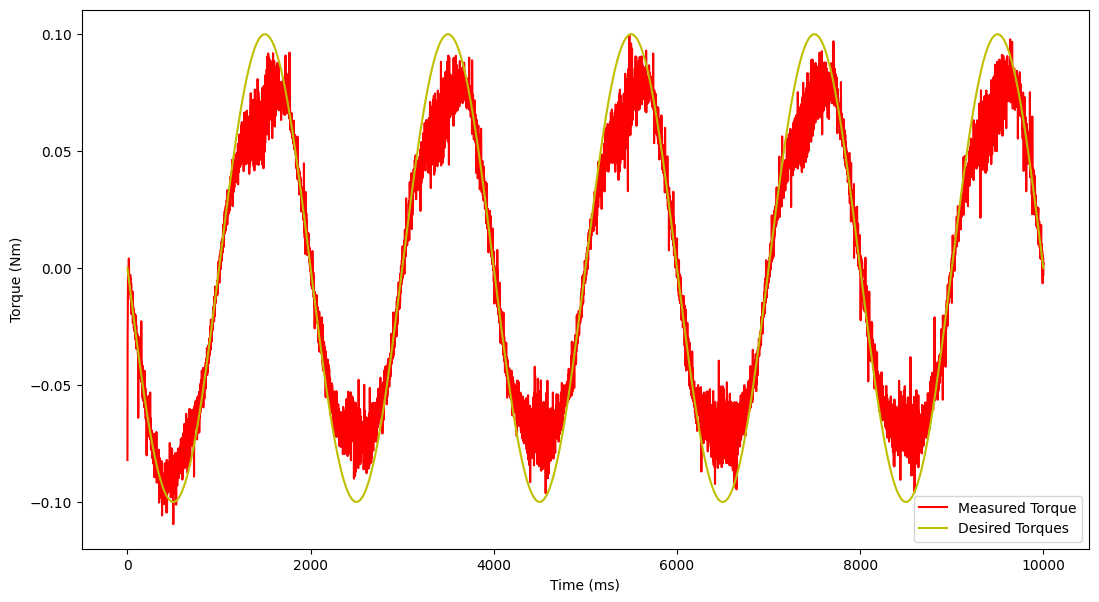

In [8]:
plt.plot(torque_finger0_lower[:, 2], c="r")
plt.plot(data["finger0"]["lower"]["desired_torques"][:, 2], c="y")
plt.legend(["Measured Torque", "Desired Torques"])
plt.xlabel("Time (ms)")
plt.ylabel("Torque (Nm)")
# plt.savefig("Torque_measured_vs_desired.png", dpi=600)

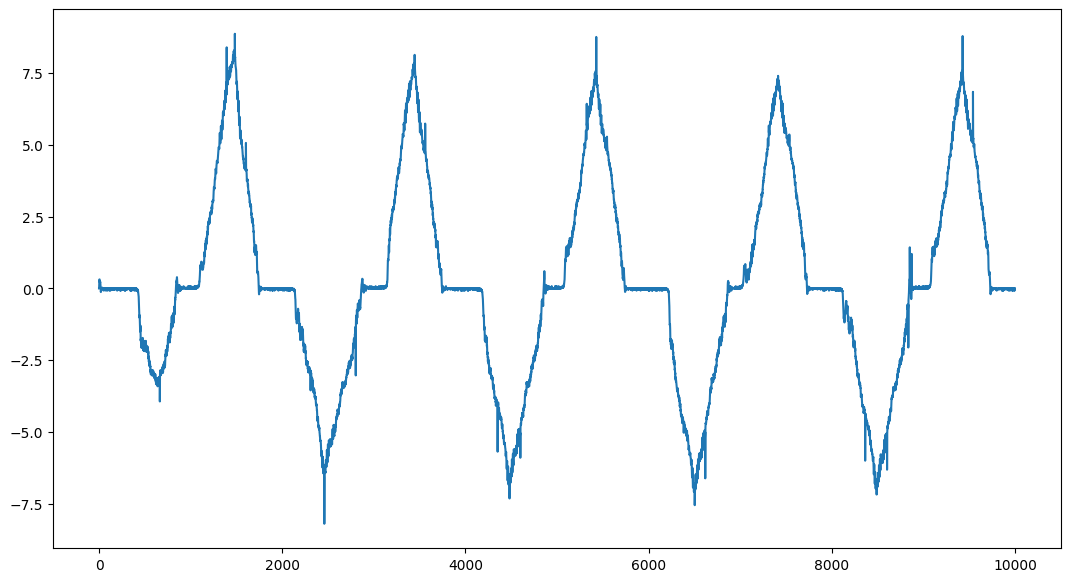

In [8]:
plt.plot(vel_finger0_lower[:, 2])

In [ ]:
plt.plot(torque_finger0_lower[:, 2], c="r")
plt.plot(id_torques_finger0_lower[:, 2], c="b")
plt.plot(torque_finger0_lower[:, 2] - id_torques_finger0_lower[:, 2], c="g")
plt.legend(["Measured Torque", "Inverse dynamic torque", "Friction Torque"])

## Fitting the simple Coulomb friction model $\tau_f = F_c \tanh(\alpha\dot{q})$

In [100]:
# first we need to build the friction model
import torch
import tqdm
from torch.utils.data import DataLoader

class CoulombFrictionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Parameter(torch.tensor(0.1), requires_grad=True)
        self.alpha = torch.nn.Parameter(torch.tensor(300.0), requires_grad=True)
        
    def forward(self, x):
        return self.fc * torch.tanh(self.alpha * x)

In [101]:
# data preparation
interested_finger = "finger2"
interested_joint = "upper"
joint_idx = 0
train_data_x = torch.tensor(locals()[f"filtered_vel_{interested_finger}_{interested_joint}"][1000:, joint_idx])
train_data_y = torch.tensor(locals()[f"friction_torques_{interested_finger}_{interested_joint}"][1000:, joint_idx])
val_data_x = torch.tensor(locals()[f"filtered_vel_{interested_finger}_{interested_joint}"][7000:, joint_idx])
val_data_y = torch.tensor(locals()[f"friction_torques_{interested_finger}_{interested_joint}"][7000:, joint_idx])

In [102]:
# training loop
dataset = torch.stack([train_data_x, train_data_y])
train_loader = DataLoader(dataset, batch_size=128, shuffle=False)

In [103]:
friction_model = CoulombFrictionModel()

In [104]:
lr = 1e-4
num_epoch = 1000
optimizer = torch.optim.Adam(friction_model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

epoch_iter = tqdm.tqdm(range(num_epoch))
for i in epoch_iter:
    losses_i = []
    for batch in train_loader:
        v, true_friction = batch
        pred_friction = friction_model(v)
        loss = loss_fn(true_friction, pred_friction)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses_i.append(loss.item())
    print(f"Epoch {i}: Average loss is {np.mean(losses_i)}")

 10%|▉         | 96/1000 [00:00<00:00, 951.25it/s]

Epoch 0: Average loss is 0.0031119700608446066
Epoch 1: Average loss is 0.0031065525291297086
Epoch 2: Average loss is 0.0031011530871287874
Epoch 3: Average loss is 0.0030957721312094154
Epoch 4: Average loss is 0.0030904100524699733
Epoch 5: Average loss is 0.0030850672367421
Epoch 6: Average loss is 0.0030797436682227764
Epoch 7: Average loss is 0.003074439726169008
Epoch 8: Average loss is 0.0030691557845804822
Epoch 9: Average loss is 0.003063891819779704
Epoch 10: Average loss is 0.0030586481992108737
Epoch 11: Average loss is 0.0030534252850750163
Epoch 12: Average loss is 0.0030482234343373518
Epoch 13: Average loss is 0.0030430426115616825
Epoch 14: Average loss is 0.003037883167198975
Epoch 15: Average loss is 0.003032745446485597
Epoch 16: Average loss is 0.0030276297894536214
Epoch 17: Average loss is 0.0030225361490035896
Epoch 18: Average loss is 0.0030174644780784628
Epoch 19: Average loss is 0.00301241510899146
Epoch 20: Average loss is 0.0030073883688844986
Epoch 21: A

 19%|█▉        | 194/1000 [00:00<00:00, 965.07it/s]

Epoch 187: Average loss is 0.0024682586052693265
Epoch 188: Average loss is 0.002466502322499167
Epoch 189: Average loss is 0.0024647594008949357
Epoch 190: Average loss is 0.0024630295781594555
Epoch 191: Average loss is 0.00246131297353978
Epoch 192: Average loss is 0.002459609514934904
Epoch 193: Average loss is 0.002457918943346413


 29%|██▉       | 291/1000 [00:00<00:00, 954.01it/s]

Epoch 194: Average loss is 0.0024562413759793454
Epoch 195: Average loss is 0.0024545767413689215
Epoch 196: Average loss is 0.0024529247837919294
Epoch 197: Average loss is 0.0024512856184349513
Epoch 198: Average loss is 0.0024496591744694375
Epoch 199: Average loss is 0.002448045199423811
Epoch 200: Average loss is 0.002446443806489764
Epoch 201: Average loss is 0.0024448549254749746
Epoch 202: Average loss is 0.002443278486401847
Epoch 203: Average loss is 0.0024417142411002164
Epoch 204: Average loss is 0.0024401623001412596
Epoch 205: Average loss is 0.002438622594183609
Epoch 206: Average loss is 0.0024370948782536555
Epoch 207: Average loss is 0.002435579260982765
Epoch 208: Average loss is 0.0024340756736657967
Epoch 209: Average loss is 0.0024325838745021325
Epoch 210: Average loss is 0.002431103970206893
Epoch 211: Average loss is 0.0024296358927111644
Epoch 212: Average loss is 0.0024281794033637542
Epoch 213: Average loss is 0.0024267346069871015
Epoch 214: Average loss is

 49%|████▉     | 492/1000 [00:00<00:00, 981.28it/s]

Epoch 389: Average loss is 0.002299455745644871
Epoch 390: Average loss is 0.002299197847518999
Epoch 391: Average loss is 0.002298942866516148
Epoch 392: Average loss is 0.0022986908395788205
Epoch 393: Average loss is 0.002298441741339427
Epoch 394: Average loss is 0.0022981954861335816
Epoch 395: Average loss is 0.0022979521100732233
Epoch 396: Average loss is 0.0022977115285387458
Epoch 397: Average loss is 0.0022974737770964622
Epoch 398: Average loss is 0.0022972387721635007
Epoch 399: Average loss is 0.0022970064903048296
Epoch 400: Average loss is 0.0022967769662803495
Epoch 401: Average loss is 0.00229655011804427
Epoch 402: Average loss is 0.0022963259225209044
Epoch 403: Average loss is 0.0022961043567523882
Epoch 404: Average loss is 0.002295885397898671
Epoch 405: Average loss is 0.002295669023237524
Epoch 406: Average loss is 0.0022954552101645334
Epoch 407: Average loss is 0.002295243936193107
Epoch 408: Average loss is 0.0022950351238991197
Epoch 409: Average loss is 0.

 69%|██████▉   | 693/1000 [00:00<00:00, 981.02it/s]

Epoch 593: Average loss is 0.0022804860359231485
Epoch 594: Average loss is 0.002280470433728675
Epoch 595: Average loss is 0.0022804550832718107
Epoch 596: Average loss is 0.0022804399684857803
Epoch 597: Average loss is 0.0022804250995447192
Epoch 598: Average loss is 0.002280410460650218
Epoch 599: Average loss is 0.0022803960617948397
Epoch 600: Average loss is 0.002280381887445202
Epoch 601: Average loss is 0.0022803679349711666
Epoch 602: Average loss is 0.002280354214097891
Epoch 603: Average loss is 0.0022803407096821243
Epoch 604: Average loss is 0.002280327419152636
Epoch 605: Average loss is 0.0022803143399570468
Epoch 606: Average loss is 0.002280301469561826
Epoch 607: Average loss is 0.002280288805452296
Epoch 608: Average loss is 0.0022802763451326294
Epoch 609: Average loss is 0.002280264086125849
Epoch 610: Average loss is 0.0022802520259738294
Epoch 611: Average loss is 0.002280240162237294
Epoch 612: Average loss is 0.0022802284924958185
Epoch 613: Average loss is 0.

100%|██████████| 1000/1000 [00:00<00:00, 1013.26it/s]

Epoch 798: Average loss is 0.0022795761481905763
Epoch 799: Average loss is 0.002279575684922462
Epoch 800: Average loss is 0.002279575229147052
Epoch 801: Average loss is 0.002279574780747589
Epoch 802: Average loss is 0.002279574339608495
Epoch 803: Average loss is 0.002279573905615371
Epoch 804: Average loss is 0.0022795734786549937
Epoch 805: Average loss is 0.0022795730586153205
Epoch 806: Average loss is 0.002279572645385485
Epoch 807: Average loss is 0.002279572238855802
Epoch 808: Average loss is 0.0022795718372874956
Epoch 809: Average loss is 0.0022795714422389817
Epoch 810: Average loss is 0.0022795710536035203
Epoch 811: Average loss is 0.002279570671275546
Epoch 812: Average loss is 0.002279570295150673
Epoch 813: Average loss is 0.002279569923582517
Epoch 814: Average loss is 0.0022795695580459414
Epoch 815: Average loss is 0.002279569198439506
Epoch 816: Average loss is 0.0022795688431699996
Epoch 817: Average loss is 0.002279568493664021
Epoch 818: Average loss is 0.002

In [105]:
for param in friction_model.parameters():
    print(param)

Parameter containing:
tensor(0.0693, requires_grad=True)
Parameter containing:
tensor(299.9084, requires_grad=True)


In [106]:
pred_val_friction = friction_model(train_data_x)

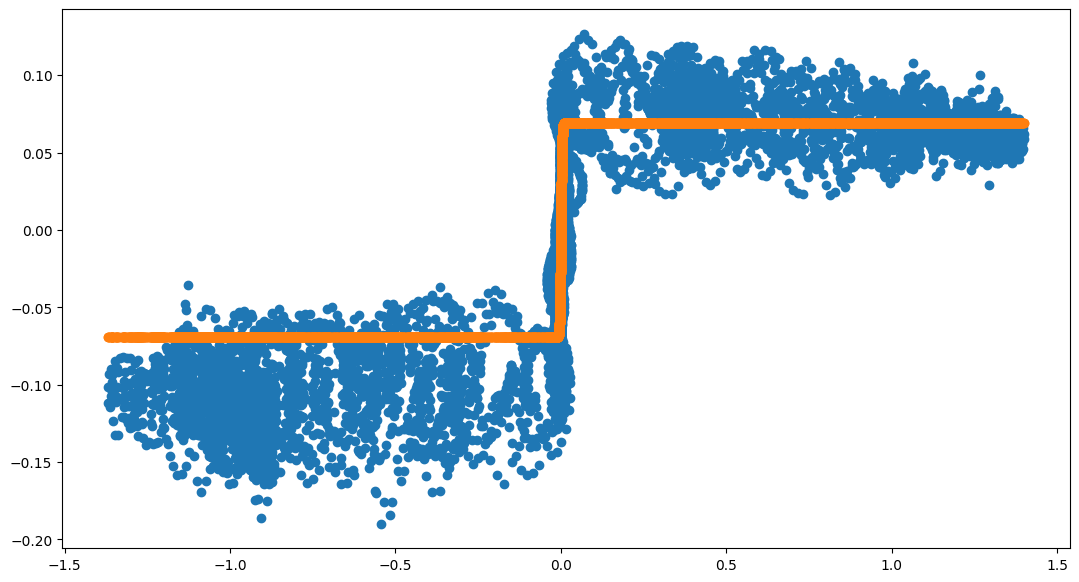

In [107]:
plt.scatter(train_data_x.cpu().numpy(), train_data_y.cpu().numpy())
plt.scatter(train_data_x.cpu().numpy(), pred_val_friction.detach().cpu().numpy())

In [ ]:
# finger 0
# lower joint: fc=0.0519 alpha=299.9316
# middle joint: fc=0.0429 alpha=299.9409
# upper joint: fc=0.0427 alpha=299.9415

# finger 2
# lower joint: fc=0.0549 alpha=299.9323
# middle joint: fc=0.0508 alpha=299.9302
# upper joint: fc=0.0693 alpha=299.9084